In [1]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381


""" categories (weight 0.1 for cycle, 0.05 for each of other three activities):
standing still: 0 or 1
walk: 0 or 1
run: 0 or 1
cycle: 0 or 1 """

' categories (weight 0.1 for cycle, 0.05 for each of other three activities):\nstanding still: 0 or 1\nwalk: 0 or 1\nrun: 0 or 1\ncycle: 0 or 1 '

In [7]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
from scipy import signal
from scipy.stats import entropy, kurtosis, skew
import matplotlib.pyplot as plt

# we'll evaluate a decision tree, a random forest, a suport vector machine and a k-nearest neighbour classifier
from sklearn.tree import DecisionTreeClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
from sklearn.tree import plot_tree # to visualize the decision tree
from sklearn.neighbors import KNeighborsClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.ensemble import RandomForestClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.svm import SVC # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# to create a test and train split
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# for plotting (you should only need to run the next two lines once)
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet
# !pip install install nodejs
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib

# Path dirs

In [3]:
# Get the path of all traces
dir_data = 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\'
dir_traces_train = dir_data + 'train\\'
dir_traces_test = dir_data + 'test\\'
dir_labels = dir_data + 'labels\\'
dir_load = dir_data + 'Loaded_data\\'


# feature extraction

In [4]:
# compute energy
def compute_energy(data):
    window_length = len(data)  # length of each window
    # Define the window function (e.g., Hanning or Hamming)
    window = np.hanning(window_length)
    # Apply the window function to the data
    windowed_data = data * window
    # Compute the FFT of the windowed data
    fft_result = np.fft.fft(windowed_data)
    # Compute the squared magnitudes of the FFT components (excluding DC)
    mag_squared = np.abs(fft_result[1:window_length // 2])**2
    # Sum the squared magnitudes and normalize by the window length
    energy = np.sum(mag_squared) / window_length
    # fft_data now contains the energy feature for each window of data
    return energy

# compute entropy
def compute_entropy(data):
    # Assume we have accelerometer data in a 3D array called "data", where each row
    # represents a window of data and each column represents a sensor axis (x, y, z or magnitute)
    window_length = len(data) # length of each window
    # Define the window function (e.g., Hanning or Hamming)
    window = np.hanning(window_length)
    # Apply the window function to the data
    windowed_data = data * window
    # Compute the FFT of the windowed data
    fft_result = np.fft.fft(windowed_data)
    # Compute the magnitudes of the FFT components (excluding DC)
    mag = np.abs(fft_result[1:window_length // 2])
    # Normalize the magnitudes to obtain a probability distribution
    mag_norm = mag / np.sum(mag)
    # Compute the information entropy of the probability distribution
    entropy = -np.sum(mag_norm * np.log2(mag_norm))
    # fft_data now contains the frequency-domain entropy feature for each window of data
    return entropy

def get_features(data):
    # get features from sliding windows
    dc = np.mean(data)
    energy = compute_energy(np.asarray(data))
    entropy = compute_entropy(np.asarray(data))
    return dc, energy, entropy

In [65]:
# add new features
def reshape_to_windows(x, wl, ol):
  """
  Segments signal into windows by reshaping it into 2D
  x: 1-d array to reshape
  wl: no. of samples in window
  ol: no. of samples overlap
  """
  assert wl>ol, 'Window must be longer than overlap'
  step=int(wl-ol)
  nrows = int(1+(x.size-wl)//step)
  n = int(x.strides[0])
  return np.lib.stride_tricks.as_strided(x, shape=(nrows,int(wl)),
                                        strides=(step*n,n))

def get_AC_DC(data, sr, order = 1, crit_freq = 2):
  """
  returns high-pass and low-pass filtered signals using butterworth filter
  data: original windowed signal
  sr = sampling frequency
  order: order of filter
  crit_freq: critical frequency of filter
  """

  sos_low = signal.butter(order, crit_freq, 'lp', fs = sr, output = 'sos')
  sos_high = signal.butter(order, crit_freq, 'hp', fs = sr, output = 'sos')
  AC = signal.sosfilt(sos_low, data)
  DC = signal.sosfilt(sos_high, data)
  return AC, DC


def extract_temporal_features(data):
  """
  returns time domain feature from windowed raw signal:
   - mean, standard deviation, kurtosis, skewness;
   - RMS, zero-crossing
   - The following percentiles: [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100] (Q)
   - Range: max(x) - min(x)
  data: windowed signal
  """
  m = np.mean(data)
  sd = np.std(data)
  kurt = kurtosis(data)
  sk = skew(data)
  rms = np.sqrt(np.mean(data**2))
  zc = np.sum(np.diff(data>=m))
  q = np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1])
  Q = np.quantile(data, q)
  range_ = Q[-1]-Q[0]             
  return m, sd, kurt, sk, rms, zc, Q, range_


def extract_frequential_features(data, sr):
  """
  exctracting frequncy domain feature from windowed Fourier transform:
   - energy, entropy, centroid, bandwidth, max_freq
  data: windowed signal
  sf: sampling rate
  """
  window_size = len(data)
  data -= np.mean(data)
  ft = np.fft.fft(data)/window_size
  sr = int(sr)
  # get window length
  
  #discarding mirror part
  ft = ft[:window_size//2]
  #frequencies of the transofm
  freqs = np.fft.fftfreq(window_size, 1/sr)[1:window_size//2]
  #the spectral density is the squared of the absolute
  Spec = np.abs(ft)**2
  #Energy
  E = np.sum(Spec)/(window_size//2)
  #density
  P = Spec[1:]/np.sum(Spec[1:])
  #entropy
  H = -np.sum(P*np.log2(P))/np.log2((window_size//2))
  #centriod 
  C = np.sum(P*freqs)
  #Absolute distance  of frequencies from from Centroid
  distC = np.abs((C-freqs))
  #bandwidth is the weighted mean of the distance
  BW = np.sum(distC*P)
  #maximum frequency 
  max_fr = freqs[np.argmax(Spec[1:])]
  return E, H, C, BW, max_fr

In [66]:
test_data = np.load(dir_load +'train_data_acc_seg.npy')[0]
print(extract_frequential_features(test_data, 200))

(2.783279649663905e-05, 0.5343069563196097, 5.050649615306978, 3.847473345870812, 3.0)


# Load training data

In [45]:
filenames_train = [join(dir_traces_train, f) for f in listdir(dir_traces_train) if (isfile(join(dir_traces_train, f)) and f[-5:] == '.json')]
filenames_train.sort()

## K Means clustering

In [33]:
# k_means
from sklearn.cluster import KMeans
# Load accelerometer data
magn_data = np.load(dir_load +'train_data.npy')
activity_labels = np.load(dir_load +'train_activity_label.npy')

# add feature extraction
num_features = 3
featured_data = np.zeros((magn_data.shape[0], 3))
for i in range(magn_data.shape[0]):
    featured_data[i,:] = get_features(magn_data[i])
    
# Set the number of clusters (stand still, wlak, run, cycle)
n_clusters = 4

# Create a KMeans object with the specified number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit the KMeans model to the accelerometer data
kmeans.fit(featured_data)

# Get the cluster labels for each data point
labels = kmeans.labels_


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\Loaded_data\\train_data.npy'

In [ ]:
# filter labels
data_count = np.load(dir_load + 'train_data_count.npy')
activity_labels = np.load(dir_load + 'train_activity_label.npy')
num_data = len(data_count)
stand_still = 0
walk = 0
run = 0
cycle = 0

# Sliding window: 60s
std_win = 3 #s
n = round (60 / std_win * 2 - 1)
for i in range(num_data):
    labels_count = np.zeros(4)
    print(i)
    # Get labels in the file i (window size = std_win = 10s)
    if i == 0:
        labels_i = labels[ : data_count[i]]
    else: 
        labels_i = labels[sum(data_count[:i]) : sum(data_count[:i+1])]
    labels_i_60 = labels_i.copy()
    for s in range(0, len(labels_i) - n, int(n/2+1)):
        # window = 60s 
        windowed_label = labels_i[s : s+n]
        for j in range(n): 
            # Find the label that appears the most
            for k in range(4):
                if windowed_label[j] == k:
                    labels_count[k]+=1
        label_argmax = np.where(labels_count == np.max(labels_count))
        # print(label_argmax)
        if len(label_argmax)==1:
            labels_i_60[s : s+n] = np.argmax(labels_count)
    
    # remove duplicated elements
    predicted = list(set(labels_i_60))
    activity_label = activity_labels[i]
    # match clusters with actions
    if not ((2 in predicted) ^ (activity_label[0] == 1)):
        stand_still += 1
    if not ((1 in predicted) ^ (activity_label[1] == 1)):
        walk += 1
    if not ((3 in predicted) ^ (activity_label[2] == 1)):
        run += 1
    if not ((2 in predicted) ^ (activity_label[3] == 1)):
        cycle += 1
print("stand_still acc: ", stand_still/num_data)
print("walk acc: ", walk/num_data)
print("run acc: ", run/num_data)
print("cycle acc: ", cycle/num_data)

# save labeled segment data

In [7]:
# test data for first n traces
dir_activity_labels_50 = dir_labels + 'action_labels_train.txt'
# process labels
# Open the text file in read mode
activity_labels_50 = []
with open(dir_activity_labels_50, 'r') as file:
    # Read the lines from the file
    lines = file.readlines()

    # Iterate through the lines
    for line in lines:
        # Split the line into values, and convert them to floats or integers if needed
        values = [float(x) for x in line.strip().split(',')]

        # Append the values as a row to the matrix
        activity_labels_50 += values[1:]
np.save(dir_load +'activity_labels_50.npy', np.array(activity_labels_50))


# Load data and get features

In [46]:
# Load accelerometer data and labels for windows of first 50 traces
activity_labels_50 = np.load(dir_load +'activity_labels_50.npy')
data_count = np.load(dir_load +'train_data_count.npy')
location_labels = np.load(dir_load +'train_loaction_label.npy')
magn_data_50 = np.load(dir_load +'train_data_acc_seg.npy')[:sum(data_count[:50])]
location_labels_expand = []
for i in range(len(location_labels)):
    for j in range(data_count[i]):
        location_labels_expand.append(location_labels[i])

# add feature extraction
num_features = 3
featured_data = np.zeros((magn_data_50.shape[0], num_features))
for i in range(magn_data_50.shape[0]):
    featured_data[i,] = get_features(magn_data_50[i])
    # featured_data[i,:-1] = get_features(magn_data_50[i])
    # featured_data[i,-1] = location_labels_expand[i]

In [47]:
# check training data balance
walk = np.count_nonzero(activity_labels_50 == 1)
run = np.count_nonzero(activity_labels_50 == 2)
cycle = np.count_nonzero(activity_labels_50 == 3)
stand = np.shape(activity_labels_50)[0] - walk - run
print("stand: ", stand, ", walk: ", walk, ", run: ", run, "cycle: ", cycle)

stand:  1254 , walk:  17621 , run:  312 cycle:  467


# cross validation: RF

In [10]:
# common parameter(s) to tune: max_depth and n_estimators
accs = list()
for md in np.arange(5)+1:
    accs = list()
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(magn_data_50, activity_labels_50, test_size = 0.2, shuffle = True)

        clf = RandomForestClassifier(max_depth = md, n_estimators = 100)
        clf.fit(X_train, np.array(y_train).ravel())

        test_preds = clf.predict(X_test)

        accs.append(accuracy_score(y_test, test_preds))

    print("{}:\t{}".format(md, np.round(np.mean(accs), 2)))

1:	0.92
2:	0.92
3:	0.92
4:	0.92
5:	0.95


# cross validation: SVM

In [39]:
# common parameter(s) to tune: kernel and C
accs = list()
for c in np.arange(1, 11)/10:
    accs = list()
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(featured_data, activity_labels_50, test_size = 0.2, shuffle = True)

        clf = SVC(kernel = 'rbf', C = c)
        clf.fit(X_train, np.array(y_train).ravel())

        test_preds = clf.predict(X_test)

        accs.append(accuracy_score(y_test, test_preds))

    print("{}:\t{}".format(c, np.round(np.mean(accs), 2)))

0.1:	0.92
0.2:	0.92
0.3:	0.92
0.4:	0.92
0.5:	0.92
0.6:	0.92


KeyboardInterrupt: 

# XGboost

In [49]:

X_train, X_test, y_train, y_test = train_test_split(featured_data, activity_labels_50, test_size = 0.2, shuffle = True)

# Compute the class weights based on the frequency of each class in the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Set the parameters for the XGBoost model
params = {'max_depth': 3, 'eta': 0.1, 'objective': 'multi:softmax', 'num_class': 4}

# # Create a SMOTE object to perform oversampling
# smote = SMOTE()

# # Fit the SMOTE object to the training data and oversample the minority class
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Create the XGBoost DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train the model
xgb_model = xgb.train(params, dtrain)
print("Training XGBoost classifier for activity")

# Create the XGBoost DMatrix object for the test data
dtest = xgb.DMatrix(X_test)

# Make predictions on the test set and evaluate the model
y_pred = xgb_model.predict(dtest)

print("accuracy: ", accuracy_score(y_test, y_pred))

# Save the model to a file
joblib.dump(xgb_model, 'trained_models/activity_xgboost_model_feature.joblib')

Training XGBoost classifier for activity
accuracy:  0.9437206878582595


['trained_models/activity_xgboost_model_feature.joblib']

# filter segmented labels

In [52]:
# Load the model from the file
activity_xgb_model = joblib.load('trained_models/activity_xgboost_model_feature.joblib')
magn_data = np.load(dir_load +'train_data_acc_seg.npy')
featured_data_all = np.zeros((magn_data.shape[0], 3))
for i in range(magn_data.shape[0]):
    featured_data_all[i,] = get_features(magn_data[i])
    # featured_data[i,:-1] = get_features(magn_data_50[i])
    # featured_data[i,-1] = location_labels_expand[i]
labels = activity_xgb_model.predict(xgb.DMatrix(featured_data_all))
data_count = np.load(dir_load + 'train_data_count.npy')
activity_labels = np.load(dir_load + 'train_activity_label.npy')
num_data = len(data_count)
stand_still = 0
walk = 0
run = 0
cycle = 0

# Sliding window: 60s
std_win = 10 #s
n = round (60 / std_win * 2 - 1)
for i in range(num_data):
    labels_count = np.zeros(4)
    # Get labels in the file i (window size = std_win = 10s)
    if i == 0:
        labels_i = labels[ : data_count[i]]
    else: 
        labels_i = labels[sum(data_count[:i]) : sum(data_count[:i+1])]
    # print(i, "predicted segment window: ", labels_i)
    labels_i_60 = labels_i.copy()
    for s in range(0, len(labels_i) - n, int(n/2+1)):
        # window = 60s 
        windowed_label = labels_i[s : s+n]
        for j in range(n): 
            # Find the label that appears the most
            for k in range(4):
                if windowed_label[j] == k:
                    labels_count[k]+=1
        label_argmax = np.where(labels_count == np.max(labels_count))
        # print(label_argmax)
        if len(label_argmax)==1:
            labels_i_60[s : s+n] = np.argmax(labels_count)
    
    # remove duplicated elements
    predicted = list(set(labels_i_60))
    activity_label = activity_labels[i]
    # print("predicted: ", predicted, "ground truth: ", activity_label)
    # match clusters with actions
    if not ((0 in predicted) ^ (activity_label[0] == 1)):
        stand_still += 1
    if not ((1 in predicted) ^ (activity_label[1] == 1)):
        walk += 1
    if not ((2 in predicted) ^ (activity_label[2] == 1)):
        run += 1
    if not ((3 in predicted) ^ (activity_label[3] == 1)):
        cycle += 1
print("stand still acc: ", stand_still/num_data)
print("walk acc: ", walk/num_data)
print("run acc: ", run/num_data)
print("cycle acc: ", cycle/num_data)

stand still acc:  0.6962962962962963
walk acc:  0.9555555555555556
run acc:  0.8481481481481481
cycle acc:  0.937037037037037


## test accuracy

In [142]:
data_count = np.load(dir_load + 'train_data_count.npy')
activity_labels = np.load(dir_load + 'train_activity_label.npy')
num_data = len(data_count)
stand_still = 0
walk = 0
run = 0
cycle = 0
for i in range(num_data):
    # get labels for cur data
    if i == 0:
        labels_i = labels[:data_count[i]]
    else: 
        labels_i = labels[sum(data_count[:i]):sum(data_count[:i+1])]
    # remove duplicated elements
    predicted = list(set(labels_i))
    activity_label = activity_labels[i]
    # match clusters with actions
    if not ((2 in predicted) ^ (activity_label[0] == 1)):
        stand_still += 1
    if not ((1 in predicted) ^ (activity_label[1] == 1)):
        walk += 1
    if not ((3 in predicted) ^ (activity_label[2] == 1)):
        run += 1
    if not ((2 in predicted) ^ (activity_label[3] == 1)):
        cycle += 1
print("stand_still acc: ", stand_still/num_data)
print("walk acc: ", walk/num_data)
print("run acc: ", run/num_data)
print("cycle acc: ", cycle/num_data)

stand_still acc:  0.5925925925925926
walk acc:  0.9111111111111111
run acc:  0.3851851851851852
cycle acc:  0.6


data: train_trace_118.json activities: [0 0 1 0]


Text(0, 0.5, 'Predicted activities')

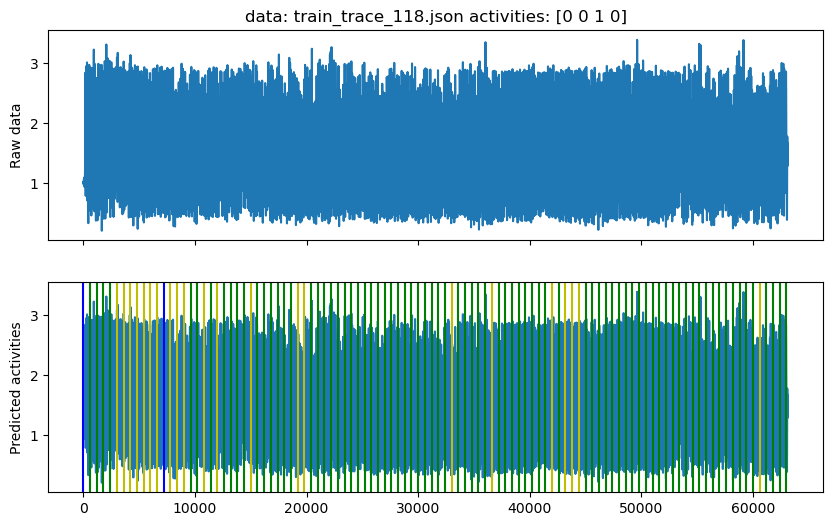

In [140]:
# plot prediction on raw data
data_count = np.load(dir_load + 'train_data_count.npy')
activity_labels = np.load(dir_load + 'train_activity_label.npy')

i = 117
filename = filenames[i]
if i == 0:
    predicts = labels[:data_count[0]]
else:
    predicts = labels[sum(data_count[:i]):sum(data_count[:i+1])]
# Plot the results
# Get accelerator data
trace = Recording(filename, no_labels=True, mute=True)
# Get time stamp and sampling rate
timestamp_raw = trace.data['ax'].timestamps
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

# Calculate raw magnitude of accelerometer signal
amagn = [sqrt(a**2+trace.data['ay'].values[i]**2+trace.data['az'].values[i]**2)for i, a in enumerate(trace.data['ax'].values)]
# divide feature windows
std_win = 3 #s
window_len = round(std_win*sampling_rate)
# get 2n sample windows, with n samples overlapping
windowed_data = [amagn[s:s+window_len] for s in range(0, len(amagn)-window_len, round(window_len/2))]

# plot
title = "data: " + filename.split('\\')[-1] + " activities: " + str(activity_labels[i])
print(title)
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].set_title(title)
ax[0].plot(amagn)
ax[0].set_ylabel('Raw data')
colors = ['b', 'g', 'r', 'y']
# ax[1].plot(amagn)
for s in  range(0, len(amagn), window_len): # adding vertical lines for the peak detection windows
    ax[1].axvline(s, color = colors[predicts[round(s/window_len)]])
ax[1].set_ylabel('Predicted activities')


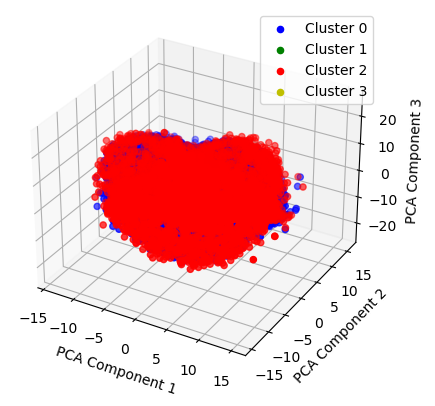

In [120]:
# Plot the data points with different colors for each cluster
from sklearn.decomposition import PCA

# perform PCA
pca = PCA(n_components=3)
data_pca = pca.fit_transform(magn_data)

# plot the data points with different colors for each cluster
cluster_points = data_pca[labels == 3]
# Plot clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['b', 'g', 'r', 'y']
for i in range(4):
    ax.scatter(data_pca[labels==i, 0], data_pca[labels==i, 1], data_pca[labels==i, 2], c=colors[i], label='Cluster {}'.format(i))
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()